<a href="https://colab.research.google.com/github/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/scintillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
#
#  Copyright 2025 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal (UKRI-STFC)

![gVXR](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/img/Logo-transparent-small.png?raw=1)

# Scintillation

In this notebook we explore how to create a detector with a scintillator.
We also shows how to plot the corresponding energy response.

<!-- 

<div class="alert alert-block alert-warning">
    <b>Note:</b> Make sure the Python packages are already installed. See <a href="../README.md">README.md</a> in the root directory of the repository. If you are running this notebook from Google Colab, please run the cell below to install the required packages.
</div> -->

## Aim and objectives of this session

<!-- The aim of this session is to replicate an actual scan.

To achieve this, the main objectives are to:-->

1. Select the scintillation material and thickness.
2. Retrieve the energy response and plot it.
3. Visualise the effect of scintillation on a phantom.

<!-- ![Screenshot of the 3D environment using K3D](https://github.com/TomographicImaging/gVXR-Tutorials/blob/main/notebooks/output_data/multi_material-CT_scan/k3d_screenshot-cropped.png?raw=1) -->

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install libnvidia-gl-575
    !pip install gvxr

## Import packages

In [3]:
import os
import numpy as np

import matplotlib # To plot images
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table

font = {'family' : 'serif',
            'size'   : 30
        }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)

from gvxrPython3 import gvxr # Simulate X-ray images
from gvxrPython3.utils import loadSpectrumSpekpy, loadSpectrumXpecgen

Where to save the plots

In [4]:
output_path = "../notebooks/output_data/scintillation"
if not os.path.exists(output_path):
    os.makedirs(output_path)

Create an OpenGL context

In [5]:
gvxr.createOpenGLContext()

Thu Jun 12 16:02:10 2025 ---- Create window (ID: -1)
Thu Jun 12 16:02:10 2025 ---- Request an interactive OpenGL context
Thu Jun 12 16:02:10 2025 ---- Initialise GLFW
Thu Jun 12 16:02:10 2025 ---- Create an OpenGL window with a 4.3 context.
Thu Jun 12 16:02:11 2025 ---- Make the window's context current
Thu Jun 12 16:02:11 2025 ---- Initialise GLEW
Thu Jun 12 16:02:11 2025 ---- OpenGL vendor: NVIDIA Corporation
Thu Jun 12 16:02:11 2025 ---- OpenGL renderer: NVIDIA GeForce RTX 4060 Ti/PCIe/SSE2
Thu Jun 12 16:02:11 2025 ---- OpenGL version: 4.3.0 NVIDIA 570.153.02
Thu Jun 12 16:02:11 2025 ---- Use OpenGL 4.5.
Thu Jun 12 16:02:11 2025 ---- Use OpenGL Compute Shader.
Thu Jun 12 16:02:11 2025 ---- Initialise the X-ray renderer if needed and if possible


Set up the detector

In [6]:
gvxr.setDetectorPosition(10.0, 0.0, 0.0, "cm")
gvxr.setDetectorUpVector(0, 0, -1)
gvxr.setDetectorNumberOfPixels(640, 320)
gvxr.setDetectorPixelSize(0.5, 0.5, "mm")

Load the sample data

In [7]:
# Locate the sample STL file from the package directory
path = os.path.dirname(gvxr.__file__)
fname = path + "/welsh-dragon-small.stl"

# Make sure it exists
if not os.path.exists(fname):
    raise IOError(fname)

# Load the file
gvxr.loadMeshFile("Dragon", fname, "mm")

# Move its bounding box centre to (0, 0, 0)
gvxr.moveToCentre("Dragon");

# Material property: Brass
gvxr.setMixture("Dragon", ["Cu", "Zn"], [0.66, 0.44])
gvxr.setDensity("Dragon", 8.73, "g.cm-3")

Thu Jun 12 16:02:13 2025 ---- file_name:	/home/fpvidal/miniconda3/envs/DIAD2gVXR/lib/python3.11/site-packages/gvxrPython3/_gvxrPython3/welsh-dragon-small.stl	nb_faces:	457345	nb_vertices:	1372035	bounding_box (in cm):	(-4.47065, -74.9368, 23.5909)	(2.37482, -59.4256, 36.0343)


Create a source

In [8]:
gvxr.setSourcePosition(-40.0,  0.0, 0.0, "cm")
gvxr.usePointSource()
#  For a parallel source, use gvxr.useParallelBeam();

Set its spectrum

In [9]:
kV = 85
filtration = [["Cu", 0.1, "mm"]]
max_number_of_energy_bins = 50

loadSpectrumXpecgen(kV, filters=filtration, th_in_deg=12, max_number_of_energy_bins=max_number_of_energy_bins);

Thu Jun 12 16:02:17 2025 (WW) addEnergyBinToSpectrum is deprecated. It will be removed in a future release. Choose addEnergyBinToSpectrumPerPixelAtSDD or addEnergyBinToSpectrumPerCm2At1m. Note that addEnergyBinToSpectrum and addEnergyBinToSpectrumPerPixelAtSDD are equivalent.
Thu Jun 12 16:02:17 2025 ---- Initialise the renderer


Compute an X-ray image

In [10]:
x_ray_image_no_scintillation = np.array(gvxr.computeXRayImage(), dtype=np.single) / gvxr.getTotalEnergyWithDetectorResponse();

Print all the possible scintillation materials

In [11]:
for material in gvxr.getSupportedScintillatorMaterials():
    print(material)

Cesium iodine
Cadmium tungstate
Yttrium oxyde
Gadolinum oxyde
Yttrium gadolinum oxyde
Gadolinum silicate
Gadox
Gadox DRZ-Plus
Sodium iodine
Lanthanum hafnate
Gadolinium gallium garnet
Yttrium aluminium garnate


Set the scintillation

```c++
void setScintillator(const std::string &aMaterial, const float &aThickness, const std::string &aUnitOfLength)
```

In [12]:
gvxr.setScintillator("CsI", 600, "um")

Plot the corresponding energy response

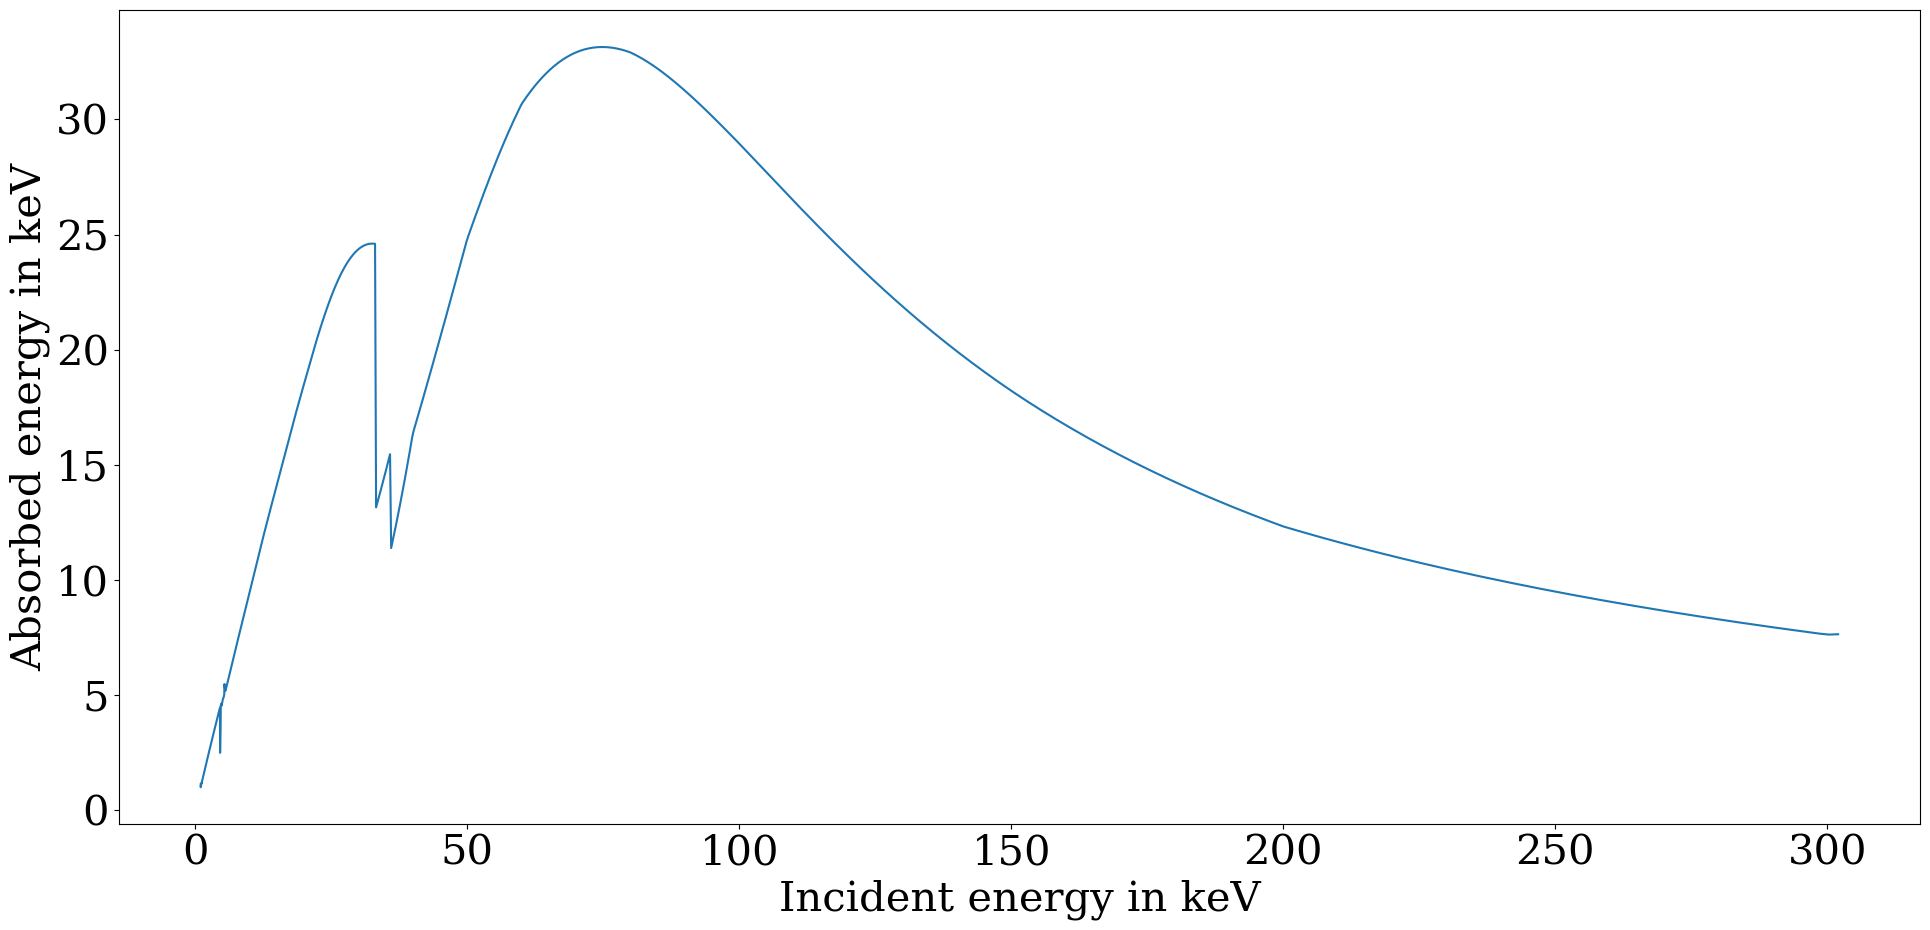

In [13]:
energy_response = np.array(gvxr.getEnergyResponse("keV"))

plt.figure(figsize= (20,10))
plt.plot(energy_response[:,0], energy_response[:,1])
plt.xlabel('Incident energy in keV')
plt.ylabel('Absorbed energy in keV')
plt.tight_layout()
plt.savefig(output_path + "/energy_response-" + gvxr.getScintillatorMaterial() + str(gvxr.getScintillatorThickness("um")) + "um.pdf")
plt.savefig(output_path + "/energy_response-" + gvxr.getScintillatorMaterial() + str(gvxr.getScintillatorThickness("um")) + "um.pdf")
plt.show()

Compute an X-ray image

In [14]:
x_ray_image_with_scintillation = np.array(gvxr.computeXRayImage(), dtype=np.single) / gvxr.getTotalEnergyWithDetectorResponse();

Display the X-ray images and compare them

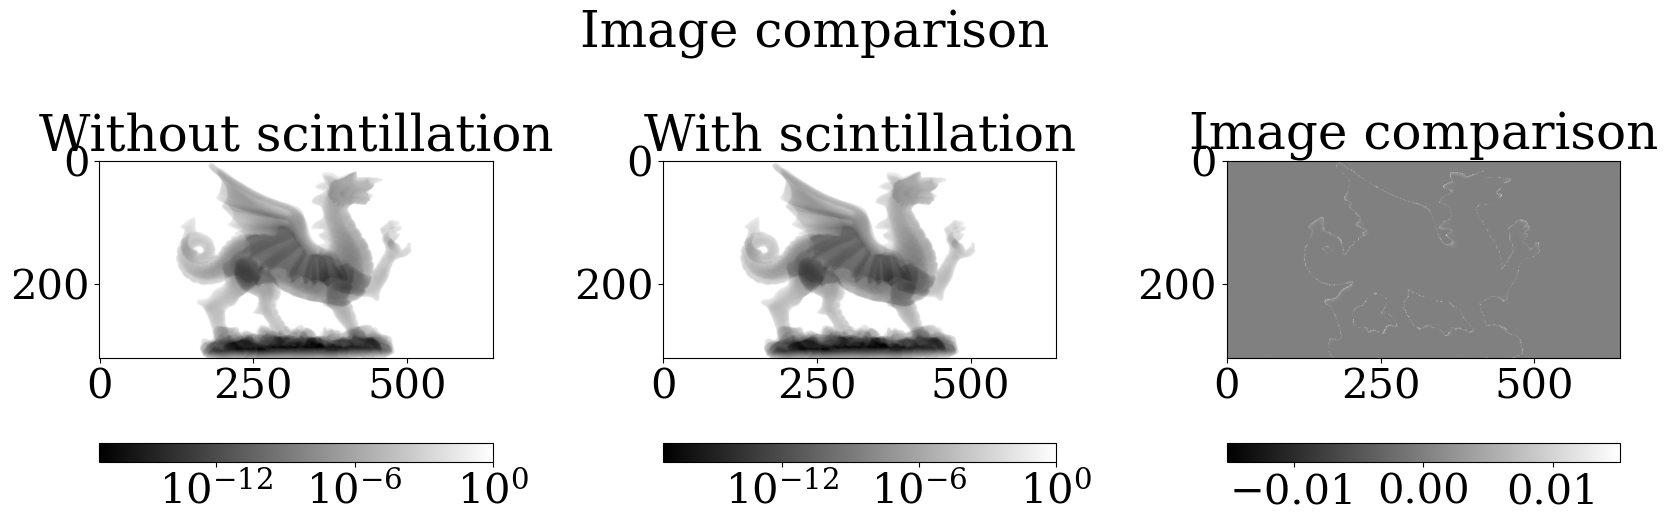

In [15]:
plt.figure(figsize=(17, 7.5))

plt.suptitle("Image comparison", y=0.75)

plt.subplot(131)
plt.imshow(x_ray_image_no_scintillation, norm=LogNorm(), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Without scintillation")

plt.subplot(132)
plt.imshow(x_ray_image_with_scintillation, norm=LogNorm(), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("With scintillation")

plt.subplot(133)
image_difference = x_ray_image_no_scintillation - x_ray_image_with_scintillation
plt.imshow(image_difference, cmap="gray", vmin=-max(image_difference.min(), image_difference.max()), vmax=max(image_difference.min(), image_difference.max()))
plt.colorbar(orientation='horizontal');
plt.title("Image comparison")

plt.tight_layout()